In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas
from collections import Counter
import os
from collections import defaultdict
from scipy.spatial import Delaunay

In [2]:
import biograph
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt

from biograph import graphplot
from biograph import hmrf_estimator
from biograph import probability_field_hmrf_estimator
from biograph import hmrf_em

import graphsonchip
import graphsonchip.analyse

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func
from graphsonchip.graphplotter import graph_plot

# Create graph

In [24]:
example_prop_frame = pandas.read_csv('Examples_prop_210216_4_individual_tile_1.csv')

loc = example_prop_frame[(example_prop_frame.x < 3500) & 
           (example_prop_frame.y < 3500) & 
           (example_prop_frame.z > 100) & 
           (example_prop_frame.z < 130)]

descriptors = ['label', 'cell_type', 'color']
n_colors = len(loc.cell_type.unique())

In [25]:
loc = loc.drop(columns = 'Unnamed: 0').drop(columns = 'Unnamed: 0.1')
loc.index = np.arange(len(loc))
loc['label'] = loc.index

In [26]:
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors
spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

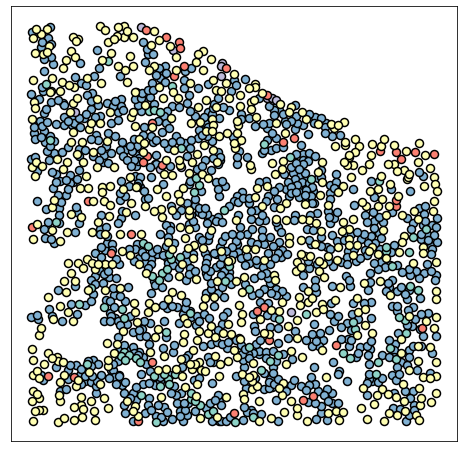

In [16]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [17]:
biograph = probability_field_hmrf_estimator.hmrf(G, K = 4, gamma = 0.2, epochs = 50)
biograph.initiate_latent_probability_field()
biograph.run()

100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


In [18]:
biograph.assign_cell_class()

<Figure size 432x288 with 0 Axes>

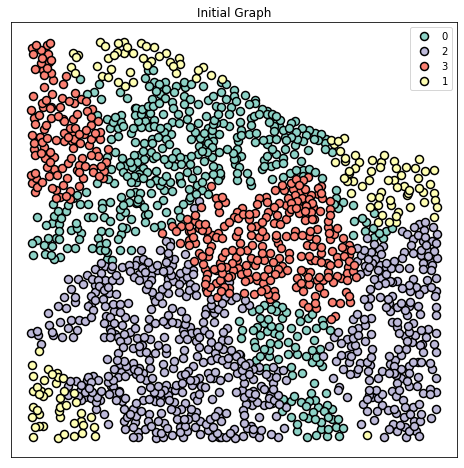

In [19]:
plt.figure()
graphplot.scatter_plot_2D(biograph.graph, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))
plt.title('Initial Graph')
plt.show()

# Initiate first classes to start the algorithm

In [20]:
K = 4
beta = 100
max_it = 20
model = hmrf_em.hmrf(G, K, beta, max_it)

In [21]:
model.initiate_model()

100%|██████████| 1699/1699 [00:00<00:00, 28248.45it/s]


In [22]:
list_param = model.run()

  0%|          | 0/20 [00:00<?, ?it/s]/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/biograph/hmrf_em.py:119: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[k,t])**2)/var[t, t]
/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/biograph/hmrf_em.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[k,t])**2)/var[t, t]
100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


In [29]:
K = 4
beta = 100
max_it = 20
model_bis = hmrf_em.hmrf(G, K, beta, max_it, KMeans = model.KMean)

In [30]:
model_bis.initiate_model()
list_param = model_bis.run()

  0%|          | 0/20 [00:00<?, ?it/s]/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/biograph/hmrf_em.py:119: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[k,t])**2)/var[t, t]
/Users/gustaveronteix/anaconda3/lib/python3.8/site-packages/biograph/hmrf_em.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[k,t])**2)/var[t, t]
100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


<Figure size 432x288 with 0 Axes>

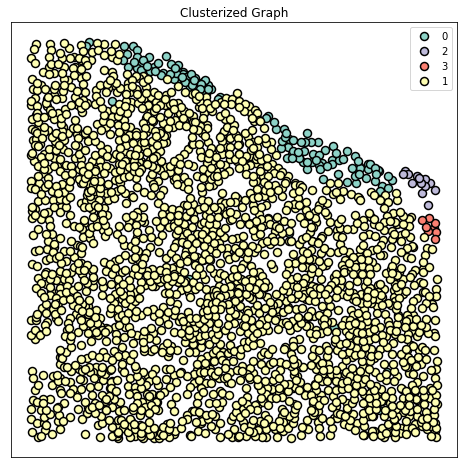

In [31]:
plt.figure()
graphplot.scatter_plot_2D(model_bis.graph, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))
plt.title('Clusterized Graph')
plt.show()

<Figure size 432x288 with 0 Axes>

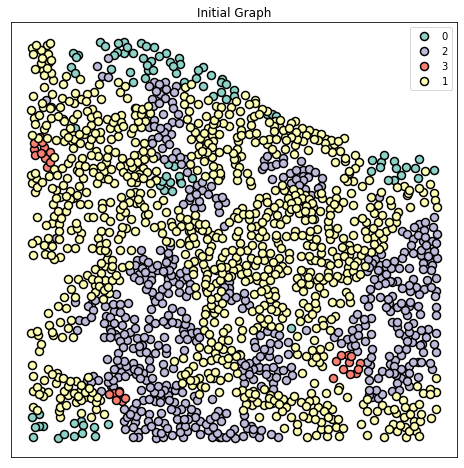

<Figure size 432x288 with 0 Axes>

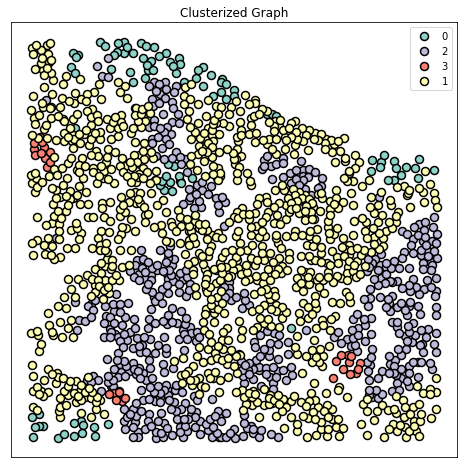

In [23]:
plt.figure()
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))
plt.title('Initial Graph')
plt.show()

plt.figure()
graphplot.scatter_plot_2D(model.graph, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))
plt.title('Clusterized Graph')
plt.show()

# Evolution of parameters during iterations

In [49]:
n_cell_type = len(loc.cell_type.unique())
color_list = [plt.cm.Set2(i) for i in range(n_cell_type)]

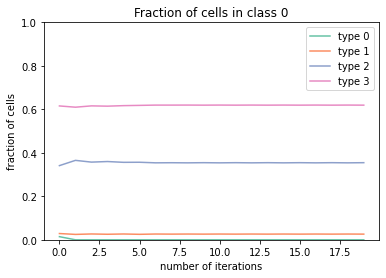

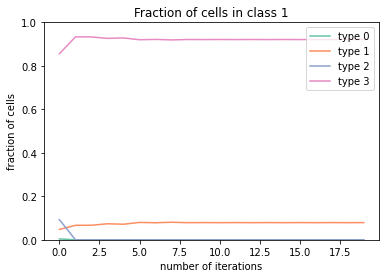

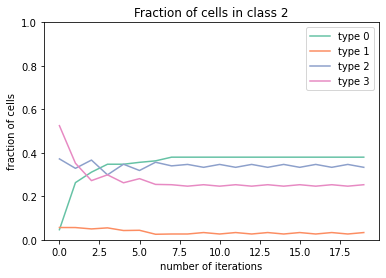

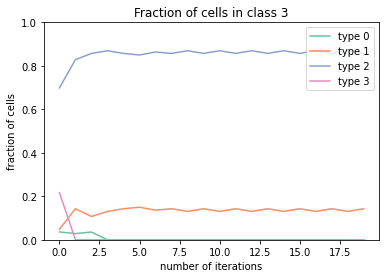

In [50]:
# Plot parameter mu

for j in range(K):
    for t in range(n_cell_type):
        plt.plot([list_param[q][0][j,t] for q in range(max_it)], c = color_list[t], label = 'type %d' %t)
    plt.title('Fraction of cells in class %d' %j)
    plt.xlabel('number of iterations')
    plt.ylabel('fraction of cells')
    plt.legend(loc = 'upper right')
    plt.ylim(0, 1)
    plt.show()

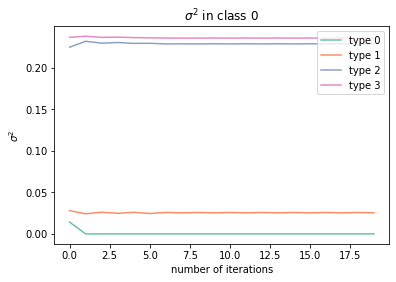

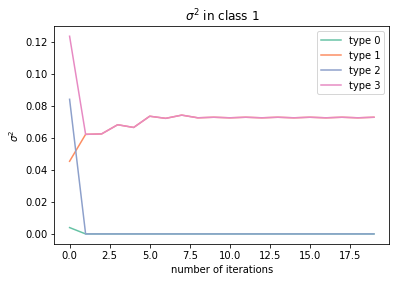

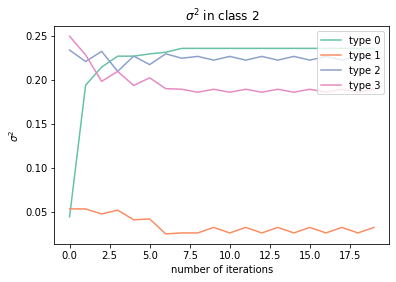

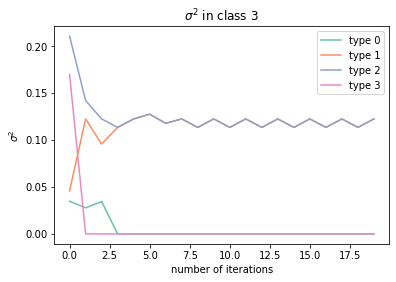

In [51]:
for j in range(K):
    plt.figure()
    for t in range(n_cell_type):
        plt.plot([list_param[q][1][j][t,t] for q in range(max_it)], c = color_list[t], label = 'type %d' %t)
    plt.title('$\sigma^2$ in class %d' %j)
    plt.xlabel('number of iterations')
    plt.ylabel('$\sigma^2$')
    plt.legend(loc = 'upper right')

# Composition of each class

<ipython-input-52-9750a40e4921>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  rects = ax.bar(x- 2*width/K + j*width/K, Y, width/(K+5), label='class %d' %j, Color = color_list[j])


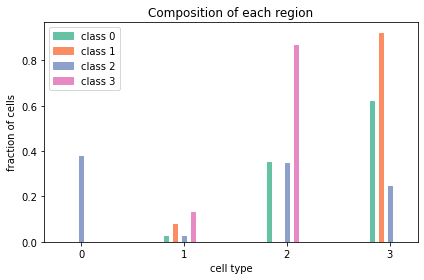

In [52]:
color_list = [plt.cm.Set2(i) for i in range(K)]

labels = [t for t in range(n_cell_type)]

width = 0.35  # the width of the bars
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
for j in range(K):
    Y = [list_param[max_it][0][j,t] for t in range(n_cell_type)]
    rects = ax.bar(x- 2*width/K + j*width/K, Y, width/(K+5), label='class %d' %j, Color = color_list[j])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('fraction of cells')
ax.set_xlabel('cell type')
ax.set_title('Composition of each region')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [134]:
def plot_compo(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.cm.Set2(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        #ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.1),
              loc='lower left', fontsize='small')

    return fig, ax

In [135]:
category_names = ['Cell type' + str(j) for j in range(K)]
results = {'class ' + str(j): [list_param[max_it][0][j,t] for t in range(n_cell_type)] for j in range(K)}

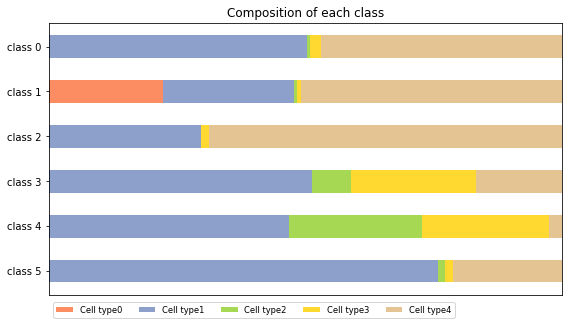

In [136]:
plot_compo(results, category_names)
plt.title('Composition of each class')
plt.show()

# Test on a random example graph

In [61]:
def single_spheroid_process(spheroid_frame:pandas.DataFrame,
                            cell_descriptors:list = []
                            ):

    """

    spheroid_frame has the label of each cell as index.

    """

    assert set(['x', 'y']).issubset(spheroid_frame.columns)
    assert set(cell_descriptors).issubset(spheroid_frame.columns)
  
    spheroid = {}
  
    cells = {}

    for ind in spheroid_frame.index:

        unique_cell = {}
    
        unique_cell['x'] = spheroid_frame.loc[ind, 'x']
        unique_cell['y'] = spheroid_frame.loc[ind, 'y']
        unique_cell['cell_label'] = ind

        for descriptor in cell_descriptors:

            unique_cell[descriptor] = spheroid_frame.loc[ind, descriptor]
            
        cells[int(ind)] = unique_cell

    spheroid['cells'] = cells

    return spheroid

In [62]:
def prep_points(cells:dict):
    
    return [[cells[cell_label]['x'], cells[cell_label]['y']] for cell_label in cells.keys()]

In [63]:
def find_neighbors(tess):
    neighbors = defaultdict(set)

    for simplex in tess.simplices:        
        for idx in simplex:
                        
            other = set(simplex)            
            other.remove(idx)
            neighbors[idx] = neighbors[idx].union(other)

    return neighbors

In [64]:
def network_plot_2D(G,
                    include_color:bool = False,
                    edge_color:str = 'k', 
                    save:bool=False,
                    figsize:tuple = (8,8),
                    alpha_line = 0.6,
                    dim_to_squeeze = 'z',
                    scatterpoint_size = 20,
                    legend = False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
    edge_max = np.max([G.degree[i] for i in G])

    # Define color range proportional to number of edges adjacent to a single node
    colors = nx.get_node_attributes(G, 'color')

    if legend:

      legend = nx.get_node_attributes(G, 'legend')

    fig, ax = plt.subplots(figsize = figsize)

    # Loop on the pos dictionary to extract the x,y,z coordinates of each node

    for i,j in enumerate(G.edges()):

        x = np.array((pos[j[0]][0], pos[j[1]][0]))
        y = np.array((pos[j[0]][1], pos[j[1]][1]))

        # Plot the connecting lines
        plt.plot(x, y, c = 'k', alpha = alpha_line)

    x = []
    y = []
    nodeColor = []
    s = []
    nodelegend = []

    for key, value in pos.items():
        x.append(value[0])
        y.append(value[1])
        s.append(scatterpoint_size)
        nodeColor.append(colors[key])

        if legend:
          nodelegend.append(legend[key])

    df = pandas.DataFrame()
    df['x'] = x
    df['y'] = y
    df['s'] = s
    df['nodeColor'] = nodeColor

    if legend:
      df['legend'] = nodelegend

    groups = df.groupby('nodeColor')

    for nodeColor, group in groups:

      if legend:

        name = group.legend.unique()[0]

        ax.plot(group.x, group.y, 
          marker='o', 
          c=nodeColor,
          markeredgewidth=1.5, 
          markeredgecolor= 'k',
          linestyle='', 
          ms=scatterpoint_size, 
          label=name)

        ax.legend()

      else:

        ax.plot(group.x, group.y, 
          marker='o', 
          c=nodeColor,
          markeredgewidth=1.5, 
          markeredgecolor= 'k',
          linestyle='', 
          ms=scatterpoint_size)

    # Scatter plot
    #sc = ax.scatter(x, y, c=nodeColor, s=s, edgecolors='k', alpha=1)
    
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # No ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 

In [65]:
# Create a basic graph random :

#N Number of nodes / Nct Number of cell types / Nedges Number of edges

def random_graph(N, Nct):

    columns = ['label', 'x', 'y', 'z', 'cell_type']
    label = np.array([i for i in range(N)])
    x = np.array([np.random.randint(0, 21) for i in range(N)])
    y = np.array([np.random.randint(0, 21) for i in range(N)])
    z = np.array([0 for i in range(N)])
    cell_type = np.array([np.random.randint(0, Nct) for i in range(N)])
    dtf = pandas.DataFrame([label, x, y, z, cell_type], columns)
    dtf = dtf.T

    descriptors = ['label', 'cell_type', 'color']
    n_colors = len(dtf.cell_type.unique())

    color_list = [plt.cm.Set3(i) for i in range(n_colors)]
    colors = [color_list[dtf.loc[i, 'cell_type']] for i in range(len(dtf))]

    dtf['color'] = colors

    spheroid = make_spheroids.single_spheroid_process(dtf, cell_descriptors = descriptors)

    cells = spheroid['cells']    
    cells_pos = prep_points(cells)
    tri = Delaunay(cells_pos)

    G=nx.Graph()

    neighbors = find_neighbors(tri)
    
    neighbors = dict(neighbors)

    for key in neighbors:
        for node in neighbors[key]:

            G.add_edge(key, node)

    pos = {int(i): (cells[i]['x'], cells[i]['y']) for i in cells.keys()}
    ind = {int(i): cells[i]['cell_label'] for i in cells.keys()}

    nx.set_node_attributes(G, pos, 'pos')
    nx.set_node_attributes(G, ind, 'cell_label')

    for descriptor in descriptors:

            desc = {int(i): (cells[i][descriptor]) for i in cells.keys()}
            nx.set_node_attributes(G, desc, descriptor)

    return G

In [165]:
G = random_graph(N = 15, Nct = 3)

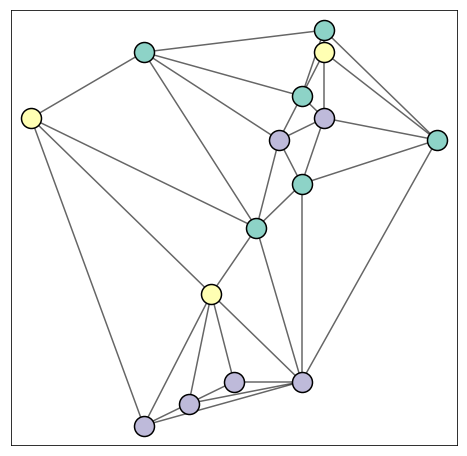

In [166]:
network_plot_2D(G, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)

#### Intermediate value of $\beta$ : clustering correct

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15029.76it/s]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:171: RuntimeWarning: invalid value encountered in true_divide
  freq[j, :] /= card_classes[j]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:177: RuntimeWarning: invalid value encountered in true_divide
  sig_j /= card_classes[j]


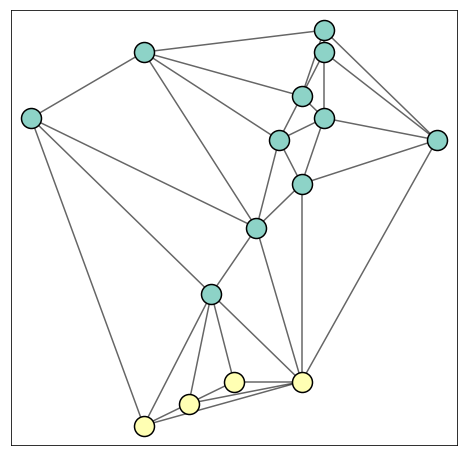

In [172]:
model = hmrf_em.hmrf(G, K = 3, beta = 1.5, max_it = 30)
model.initiate_model()
model.run()
network_plot_2D(model.graph, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)

#### Small value of $\beta$ : initial graph

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15065.75it/s]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]


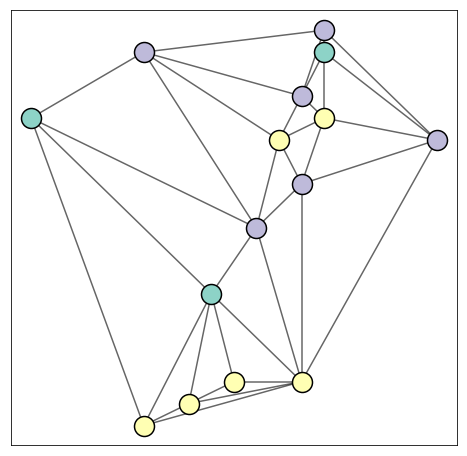

In [170]:
model = hmrf_em.hmrf(G, K = 3, beta = 0, max_it = 30)
model.initiate_model()
model.run()
network_plot_2D(model.graph, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)

#### Large value of $\beta$ : wrong clustering

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 7521.17it/s]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:171: RuntimeWarning: invalid value encountered in true_divide
  freq[j, :] /= card_classes[j]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:177: RuntimeWarning: invalid value encountered in true_divide
  sig_j /= card_classes[j]


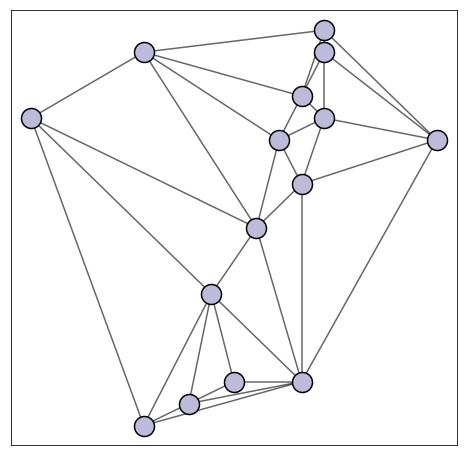

In [171]:
model = hmrf_em.hmrf(G, K = 3, beta = 10, max_it = 10)
model.initiate_model()
model.run()
network_plot_2D(model.graph, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)